# Siamese

Source: https://keras.io/examples/mnist_siamese/

In [1]:
import os
import h5py
from time import time, strftime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import ipyvolume as ipv
import pathlib

import sys
sys.path.append("..") 
from cryoem.projections import RotationMatrix

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

from tensorflow_graphics.util import shape
from tensorflow_graphics.geometry.transformation import quaternion, euler
from tensorflow_graphics.util import asserts
from tensorflow_graphics.math import vector
from tensorflow_graphics.util import safe_ops

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12649410705344085501
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 712830616622454244
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15653649964973803733
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10638308716109273355
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:2"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4599322060955805350
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      devi

## Read data 

In [3]:
angle_ranges = "2.0,0.4,2.0"
angle_shift = "0.0,0.0,0.0"
num_projections = 5000
dir_name = "../data/"
projections_filename = f"5j0n_ProjectionsAngles_ProjNber{num_projections}_AngCoverage{angle_ranges}_AngShift{angle_shift}"


# load structures
data = h5py.File(os.path.join(dir_name, f"{projections_filename}.h5"), 'r')

X, y = data['Projections'], data['Angles']
print(f"{X.shape[0]} projections of images with dimension {X.shape[1:]} pixels")
print(f"{y.shape[0]} sets of {y.shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [4]:
# plot coverage
all_vectors = RotationMatrix(y)
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.pylab.save(f"data/angle_variety/{angle_ranges}.html")
ipv.show()

## Distances


#### Angle Distance

In [5]:
def euler2quaternion(angles):
    """
    Quaternion implements 3 rotations along x, y, z axis. 
    We compose them to get the final (single) rotation.
    """
    with tf.compat.v1.name_scope(None, "quaternion_from_euler", [angles]):
        #print(angles)
        a = [angles[i] for i in range(len(angles))]

        a = tf.convert_to_tensor(value=a)

        shape.check_static(tensor=a, tensor_name="angles", has_dim_equals=(-1, 3))

        half_angles = a / 2.0
        cos_half_angles = tf.cos(half_angles)
        sin_half_angles = tf.sin(half_angles)
        c1, c2, c3 = tf.unstack(cos_half_angles, axis=-1)
        s1, s2, s3 = tf.unstack(sin_half_angles, axis=-1)
        # Tait-Bryan angles
        #w = c1 * c2 * c3 + s1 * s2 * s3
        #x = -c1 * s2 * s3 + s1 * c2 * c3
        #y = c1 * s2 * c3 + s1 * c2 * s3
        #z = -s1 * s2 * c3 + c1 * c2 * s3
        
        # Euler angles
        w = c1*c2*c3 - s1*c2*s3
        x = c1*s2*s3 - s1*s2*c3
        y = c1*s2*c3 + s1*s2*s3
        z = c1*c2*s3 + s1*c2*c3
        return tf.stack((x, y, z, w), axis=-1)

def d_q(q1, q2):
     with (tf.compat.v1.name_scope(None, "quaternion_relative_angle",[q1, q2])):
        q1 = tf.convert_to_tensor(value=q1)
        q2 = tf.convert_to_tensor(value=q2)
      
        shape.check_static(
            tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
        shape.check_static(
            tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

        q1 = quaternion.normalize(q1)
        q2 = quaternion.normalize(q2)
        
        dot_product = vector.dot(q1, q2, keepdims=False)
        
        # Ensure dot product is in range [-1. 1].
        const = 1.8 #4.0 #.63
        eps_dot_prod = const * asserts.select_eps_for_addition(dot_product.dtype)
        dot_product = safe_ops.safe_shrink(
            dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

        return 2.0 * tf.acos(tf.abs(dot_product)) 

In [6]:
assert (d_q(euler2quaternion([np.pi/2]*3), euler2quaternion([2*np.pi-np.pi/2]*3))-np.pi) < 1e-7

#### Projection Distance

In [7]:
def d_p(p1, p2):
    # (learned) distance between two images.
    # for now, Euclid dist
    p1 = tf.convert_to_tensor(value=p1, dtype=np.float64)
    p2 = tf.convert_to_tensor(value=p2, dtype=np.float64)

    if len(p1.shape) > 1:
        dist = tf.norm(p1-p2, ord='euclidean', axis=1, keepdims=True)
    else:
        dist = tf.norm(p1-p2, ord='euclidean')

    return dist

In [8]:
assert tf.reduce_mean(d_p(X[0:3], X[0:3])) < 1e-7

---

## kNN of the Projections

In [9]:
k = 5

In [10]:
def get_knn_output(k):
    start_time = time()

    _X = np.reshape(X, (X.shape[0], -1))
    
    name = projections_filename.split('/')[-1]
    if not os.path.exists(f'data/knn{k}_{name}_distances.npy'):
        nbrs = NearestNeighbors(n_neighbors=k, metric=d_p, algorithm='ball_tree', n_jobs=-1).fit(_X)
        distances_p, indices_p = nbrs.kneighbors(_X)
        A_p = nbrs.kneighbors_graph(_X).toarray()

        try:
            np.save(f'data/knn{k}_{name}_indices', indices_p)         # Indices of the nearest points in the population matrix
            np.save(f'data/knn{k}_{name}_distances', distances_p)     # Array representing the lengths to points
            np.save(f'data/knn{k}_{name}_A', A_p)                     # Sparse graph showing the connections between neighboring points
        except:
            pass
        print(f"--- {time() - start_time} seconds ---")
    
    else:
        indices_p     = np.load(f'data/knn{k}_{name}_indices.npy')     # shape: NUM_IMGS, NUM_NEIGHBOURS
        distances_p   = np.load(f'data/knn{k}_{name}_distances.npy')   # shape: NUM_IMGS, NUM_NEIGHBOURS
        A_p           = np.load(f'data/knn{k}_{name}_A.npy')           # shape: NUM_IMGS, NUM_IMGS

    
    return indices_p, distances_p, A_p 

In [11]:
# --- 23594.572999954224 seconds ---
indices_p, distances_p, A_p = get_knn_output(k=k)

In [12]:
np.max(distances_p)

63.95002548806251

---

## Prepare for training

In [113]:
def sample_pairs(projections_range, num_pairs, style="random", k=None):
    if not k and style != "random":
        raise ValueError("Please specify k for kNN for sample_pairs method")
    
    if style=="random":
        idx1 = list(np.random.randint(projections_range[0], projections_range[1], num_pairs))
        idx2 = list(np.random.randint(projections_range[0], projections_range[1], num_pairs))
    
    elif style=="knn":
        idx1 = list(np.random.randint(projections_range[0], projections_range[1], num_pairs))
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]
 
    elif style=="knn_and_random":
        # select random sample for the first element of pair
        idx1 = list(np.random.randint(projections_range[0], projections_range[1], num_pairs))
        
        # half from kNN
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
        idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
        # half random
        idx2 = idx2_knn + idx2_random
        
    return idx1, idx2

In [14]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))

def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

def create_pairs(x, y, projections_range, num_pairs):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    
    # Sample some pairs.
    idx1, idx2 = sample_pairs(projections_range=projections_range, num_pairs=num_pairs, style="knn_and_random", k=k)
    
    for z1, z2 in zip(idx1, idx2):
        pairs += [[x[z1], x[z2]]]
        labels += [d_q(euler2quaternion(y[z1]), euler2quaternion(y[z2]))]

    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_x = Input(shape=input_shape)

    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    x = Conv2D(filters=32, kernel_size=[7, 7], activation='relu', padding='same', kernel_initializer='glorot_uniform')(input_x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(64, [5, 5], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(256, [1, 1], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = AvgPool2D(pool_size=[8, 8], padding='same')(x)

    x = tf.squeeze(x, axis=[1,2])
    
    return Model(input_x, x)

## Training

In [15]:
EPOCHS = 100
BATCH_SIZE = 256
NUM_PROJECTIONS = 5000
NUM_PAIRS = 50000
LR = 0.001
CHECKPOINT_PATH = f"training/{strftime('%Y%m%d_%H%M%S')}"
pathlib.Path(CHECKPOINT_PATH).mkdir(parents=True, exist_ok=True)

In [16]:
# # the data, split between train and test sets
# train_idx, test_idx, _, _ = train_test_split(range(NUM_PAIRS), 
#                                              range(NUM_PAIRS), 
#                                              test_size=0.33, 
#                                              random_state=42)
# train_idx, val_idx, _, _ = train_test_split(train_idx, 
#                                             train_idx, 
#                                             test_size=0.25, 
#                                             random_state=1)

# train_idx = sorted(train_idx)
# val_idx = sorted(val_idx)
# test_idx = sorted(test_idx)

In [17]:
tr_pairs, tr_y = create_pairs(X, y, projections_range=[0, 3000], num_pairs=40000)
tr_pairs = tr_pairs.reshape(list(tr_pairs.shape) + [-1])
tr_y = tf.cast(tr_y, dtype=tf.float32)

val_pairs, val_y = create_pairs(X, y, projections_range=[3000, 4000], num_pairs=10000)
val_pairs = val_pairs.reshape(list(val_pairs.shape) + [-1])
val_y = tf.cast(val_y, dtype=tf.float32)

te_pairs, te_y = create_pairs(X, y, projections_range=[4000, 5000], num_pairs=10000)
te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
te_y = tf.cast(te_y, dtype=tf.float32)

In [18]:
input_shape = val_pairs[:, 0].shape[1:]
print(f"Input images shape {input_shape}")

Input images shape (116, 116, 1)


In [19]:
tr_pairs.shape

(40000, 2, 116, 116, 1)

In [20]:
te_pairs[:, 0].shape

(10000, 116, 116, 1)

In [21]:
te_y.shape

TensorShape([10000])

In [22]:
# network definition
base_network = create_base_network(input_shape)


input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)



# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)



distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])



model = Model([input_a, input_b], distance)


# train
#optimizer = RMSprop()
optimizer = Adam(learning_rate=LR)

model.compile(loss=mse, optimizer=optimizer, metrics=['mae'])

model.summary()


# Create a callback that saves the model's weights
backup_callback = ModelCheckpoint(filepath=CHECKPOINT_PATH,
                              save_weights_only=True,
                              verbose=1)

history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=([val_pairs[:, 0], val_pairs[:, 1]], te_y),
                  callbacks=[backup_callback])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          159744      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

Epoch 26/100
39936/40000 [============================>.] - ETA: 0s - loss: 0.0430 - mae: 0.1641
Epoch 00026: saving model to training/20191212_154741
40000/40000 [==============================] - 81s 2ms/sample - loss: 0.0430 - mae: 0.1641 - val_loss: 0.9332 - val_mae: 0.7881
Epoch 27/100
39936/40000 [============================>.] - ETA: 0s - loss: 0.0420 - mae: 0.1622
Epoch 00027: saving model to training/20191212_154741
40000/40000 [==============================] - 81s 2ms/sample - loss: 0.0420 - mae: 0.1622 - val_loss: 0.9305 - val_mae: 0.7870
Epoch 28/100
39936/40000 [============================>.] - ETA: 0s - loss: 0.0411 - mae: 0.1602
Epoch 00028: saving model to training/20191212_154741
40000/40000 [==============================] - 80s 2ms/sample - loss: 0.0411 - mae: 0.1602 - val_loss: 0.9405 - val_mae: 0.7913
Epoch 29/100
39936/40000 [============================>.] - ETA: 0s - loss: 0.0416 - mae: 0.1609
Epoch 00029: saving model to training/20191212_154741
40000/40000 

Epoch 56/100
39936/40000 [============================>.] - ETA: 0s - loss: 0.0314 - mae: 0.1380
Epoch 00056: saving model to training/20191212_154741
40000/40000 [==============================] - 80s 2ms/sample - loss: 0.0314 - mae: 0.1380 - val_loss: 0.9292 - val_mae: 0.7860
Epoch 57/100
39936/40000 [============================>.] - ETA: 0s - loss: 0.0316 - mae: 0.1382
Epoch 00057: saving model to training/20191212_154741
40000/40000 [==============================] - 80s 2ms/sample - loss: 0.0316 - mae: 0.1382 - val_loss: 0.9516 - val_mae: 0.7953
Epoch 58/100
39936/40000 [============================>.] - ETA: 0s - loss: 0.0317 - mae: 0.1387
Epoch 00058: saving model to training/20191212_154741
40000/40000 [==============================] - 80s 2ms/sample - loss: 0.0317 - mae: 0.1387 - val_loss: 0.9253 - val_mae: 0.7832
Epoch 59/100
39936/40000 [============================>.] - ETA: 0s - loss: 0.0315 - mae: 0.1379
Epoch 00059: saving model to training/20191212_154741
40000/40000 

Epoch 86/100
39936/40000 [============================>.] - ETA: 0s - loss: 0.0275 - mae: 0.1274
Epoch 00086: saving model to training/20191212_154741
40000/40000 [==============================] - 80s 2ms/sample - loss: 0.0275 - mae: 0.1274 - val_loss: 0.9450 - val_mae: 0.7926
Epoch 87/100
39936/40000 [============================>.] - ETA: 0s - loss: 0.0276 - mae: 0.1279
Epoch 00087: saving model to training/20191212_154741
40000/40000 [==============================] - 80s 2ms/sample - loss: 0.0276 - mae: 0.1279 - val_loss: 0.9303 - val_mae: 0.7861
Epoch 88/100
39936/40000 [============================>.] - ETA: 0s - loss: 0.0275 - mae: 0.1280
Epoch 00088: saving model to training/20191212_154741
40000/40000 [==============================] - 80s 2ms/sample - loss: 0.0275 - mae: 0.1280 - val_loss: 0.9551 - val_mae: 0.7972
Epoch 89/100
39936/40000 [============================>.] - ETA: 0s - loss: 0.0274 - mae: 0.1276
Epoch 00089: saving model to training/20191212_154741
40000/40000 

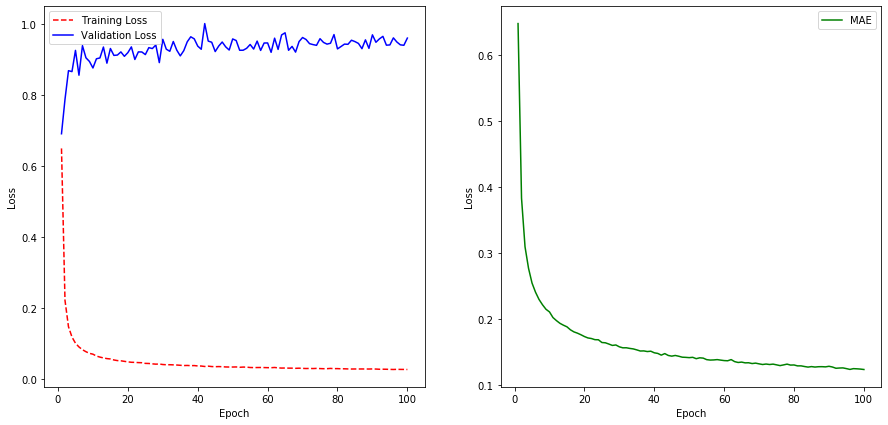

In [42]:
# Get training and test loss histories
training_loss = history.history['loss']
val_loss = history.history['val_loss']
maes = history.history['mae']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, 'r--')
ax1.plot(epoch_count, val_loss, 'b-')
ax1.legend(['Training Loss', 'Validation Loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count, maes, 'g-')
ax2.legend(['MAE'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show();

In [56]:
y_tr_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
y_val_pred = model.predict([val_pairs[:, 0], val_pairs[:, 1]])

In [74]:
def plot_results(projections, y_pred, y, strtype):
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(projections[i, 0])
        ax2.imshow(projections[i, 1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

plot_train_results = plot_results(tr_pairs, y_tr_pred, tr_y, "Train")
plot_validation_results = plot_results(val_pairs, y_val_pred, te_y, "Validation")

--- Train Set ---
predicted: 0.9891369342803955
true:      0.9225376844406128
mse:       0.0044354600831866264
mae:       0.06659924983978271


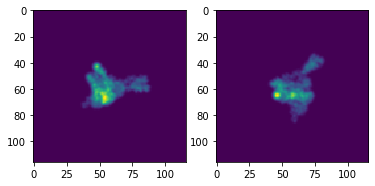

In [75]:
plot_train_results(1)

--- Validation Set ---
predicted: 2.0328640937805176
true:      2.753279685974121
mse:       0.5189986228942871
mae:       0.7204155921936035


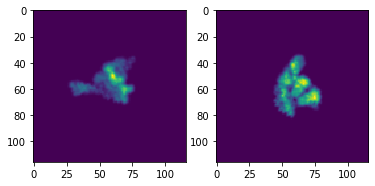

In [76]:
plot_validation_results(0)

Started 15:58+2.5H

In [ ]:
stop here

In [43]:
model_filename = f"training/{strftime('%Y%m%d_%H%M%S')}.h5"
model.save(model_filename) 
print(f"Model saved to: {model_filename}")

Model saved to: training/20191212_181853.h5


### Read model from file

In [81]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          159744      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [82]:
y_tr_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
y_val_pred = model.predict([val_pairs[:, 0], val_pairs[:, 1]])

--- Train Set ---
predicted: 0.9891369342803955
true:      0.9225376844406128
mse:       0.0044354600831866264
mae:       0.06659924983978271


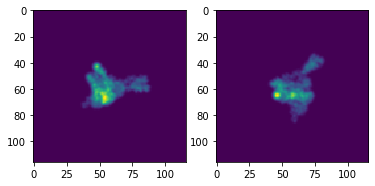

In [83]:
plot_train_results(1)

--- Validation Set ---
predicted: 2.0328640937805176
true:      2.753279685974121
mse:       0.5189986228942871
mae:       0.7204155921936035


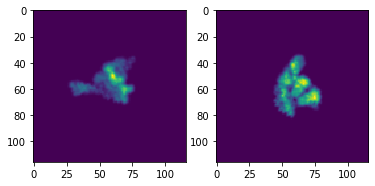

In [84]:
plot_validation_results(0)

---

In [85]:
import pandas as pd
import seaborn as sns; sns.set(style="white", color_codes=True)

In [95]:
# Creating the dataframe for SNS plot
data = {"d_Q" : tr_y.numpy(),
        "d_P" : y_tr_pred.T[0]}
df = pd.DataFrame(data=data)

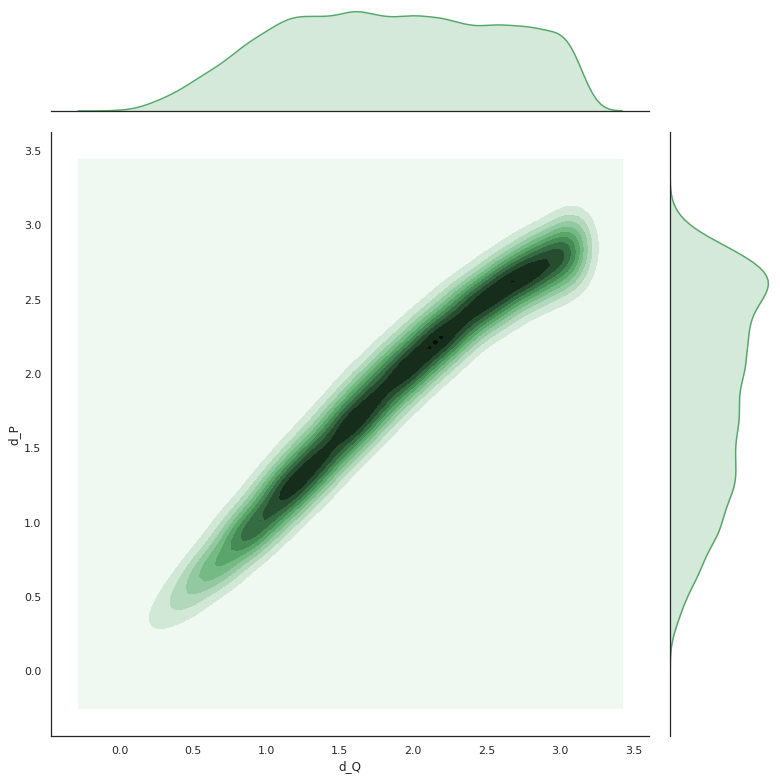

In [96]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="kde", color="g", height=11)  # "reg", "kde"

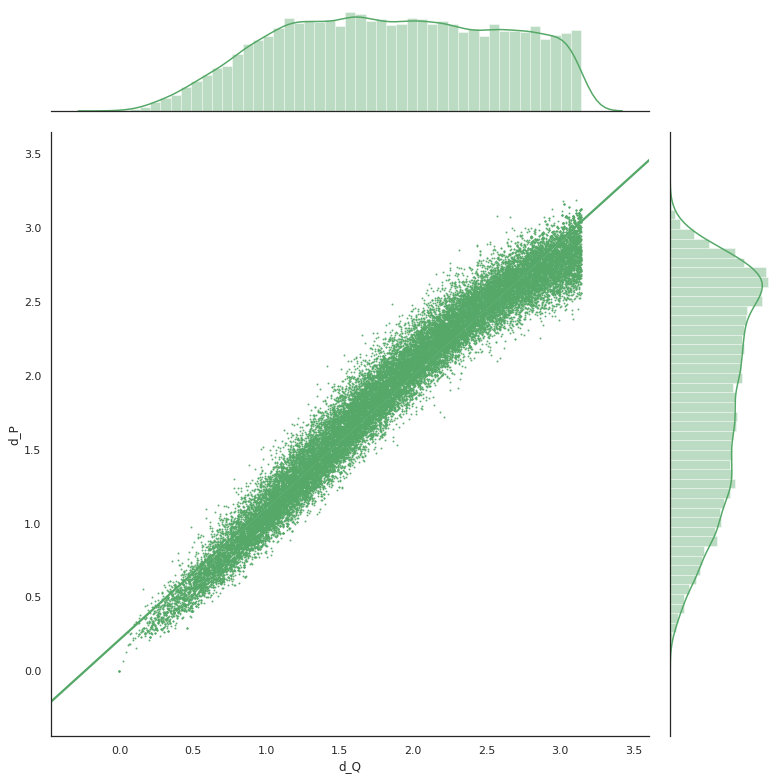

In [97]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="reg", color="g", height=11, scatter_kws={"s": 1})  # "reg", "kde"

In [98]:
from scipy.stats import linregress

lr = linregress(df.d_Q, df.d_P)
slope, intercept = lr.slope, lr.intercept
print(f"d_P/d_Q = {slope}, intercept = {intercept}")

d_P/d_Q = 0.9003444525170873, intercept = 0.21071254983578314


---

In [90]:
# Creating the dataframe for SNS plot
data = {"d_Q" : val_y.numpy(),
        "d_P" : y_val_pred.T[0]}
df = pd.DataFrame(data=data)

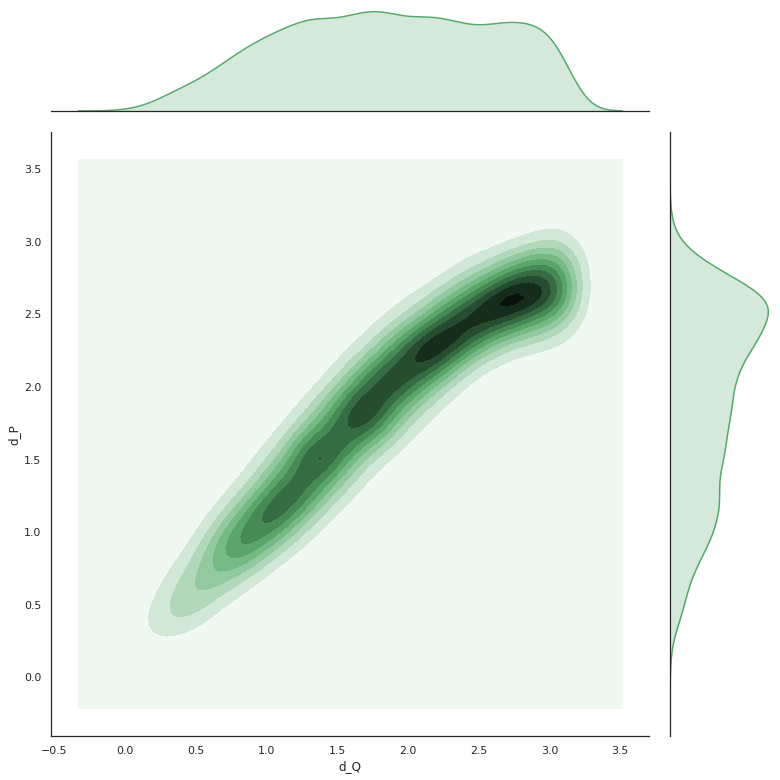

In [91]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="kde", color="g", height=11)  # "reg", "kde"

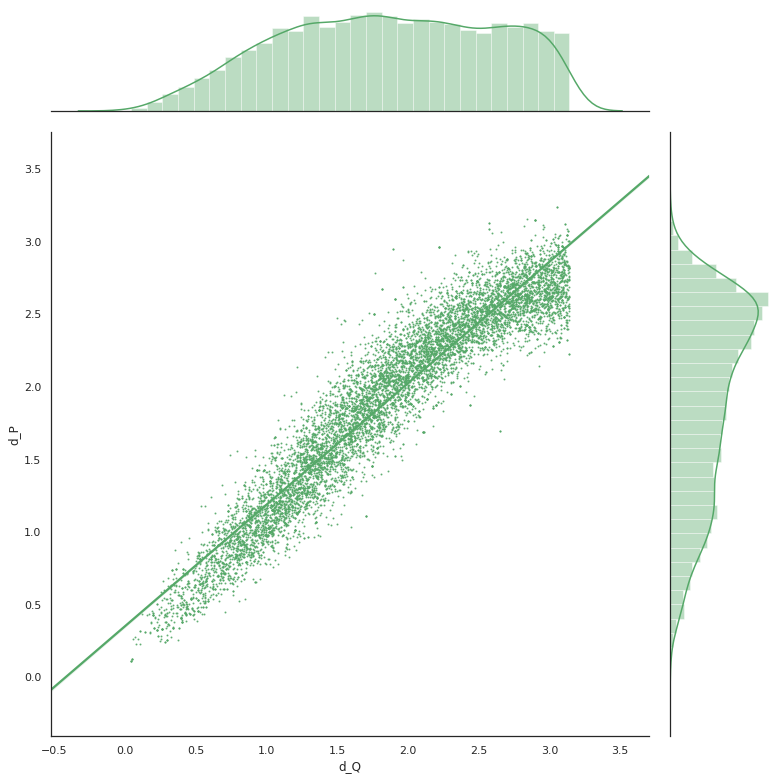

In [92]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="reg", color="g", height=11, scatter_kws={"s": 1})  # "reg", "kde"

In [94]:
# from scipy.stats import linregress

# lr = linregress(df.d_Q, df.d_P)
# slope, intercept = lr.slope, lr.intercept
# print(f"d_P/d_Q = {slope}, intercept = {intercept}")

---

###### Predicted Angles

In [100]:
low_ang = [float(x)*np.pi for x in angle_shift.split(",")]
high_ang = [float(x)*np.pi for x in angle_ranges.split(",")]

euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(NUM_PROJECTIONS, 3))

angles_predicted = [tf.Variable(e) for e in euler]
print(f"Angles predicted: (min, max) = ({tf.reduce_min(angles_predicted):.4f}, {tf.reduce_max(angles_predicted):.4f})")

angles_predicted = np.array(angles_predicted)
angles_predicted.shape

Angles predicted: (min, max) = (0.0003, 6.2829)


(5000,)

## Loss and gradient

Our goal is to then optimize
$$ \operatorname*{arg\,min}_{\{\hat{Q}_i\}_{i=1}^n} \sum_{\{i,j |d_p(p_i, p_j) < \epsilon\}} \left| d_p(p_i, p_j) - d_Q(\hat{Q}_i, \hat{Q}_j) \right|^2, $$
where $p_i$ is a projected image and $d_p$ is a (learned) distance between two images.

In [101]:
def loss(a1_predicted, a2_predicted, distance_target, dt_type, space):
    a1_predicted = list(a1_predicted)
    a2_predicted = list(a2_predicted)
    
    q1 = euler2quaternion(a1_predicted)
    q2 = euler2quaternion(a2_predicted)
    
    distance = d_q(q1, q2)
    
    if space == "dQspace":
        if dt_type == "dP":
            # Convert dP to dQ
            distance_target = (distance_target-intercept)/slope
            
    elif space == "dPspace":
        if dt_type == "dP":
            # Convert dQ to dP
            distance = tf.math.polyval(coeffs4dP, distance)
        elif dt_type == "dQ":
            distance = tf.math.polyval(coeffs4dP, distance)
            distance_target = tf.math.polyval(coeffs4dP, distance_target)  

    # The mean doesn't depend on the batch size.
    return tf.reduce_mean((distance - distance_target)**2)

In [102]:
def gradient(a1_predicted, a2_predicted, distance_target, dt_type, space):
    with tf.GradientTape() as tape:
        loss_value = loss(a1_predicted, a2_predicted, distance_target, dt_type, space)
        gradient = tape.gradient(loss_value, a1_predicted + a2_predicted)
        
    return loss_value, gradient

In [103]:
def sample_pairs(n_samples, batch_size, style="random", k=None):
    if not k and style != "random":
        raise ValueError("Please specify k for kNN for sample_pairs method")
    
    if style=="random":
        idx1 = list(np.random.randint(0, NUM_PROJECTIONS, batch_size))
        idx2 = list(np.random.randint(0, NUM_PROJECTIONS, batch_size))
    
    elif style=="knn":
        idx1 = list(np.random.randint(0, NUM_PROJECTIONS, batch_size))
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]
 
    elif style=="knn_and_random":
        # select random sample for the first element of pair
        idx1 = list(np.random.randint(0, NUM_PROJECTIONS, batch_size))
        
        # half from kNN
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:batch_size//2]]
        idx2_random = list(np.random.randint(0, NUM_PROJECTIONS, batch_size//2))
        # half random
        idx2 = idx2_knn + idx2_random
        
    return idx1, idx2

In [104]:
def loss_predicted_vs_true_angle(steps, batch_size, optimization=False):
    losses = np.empty(steps)
    time_start = time()
    optimizer = Adam(learning_rate=0.001)
    
    for step in range(1, steps+1):

        # Sample some pairs.
        #idx1, idx2 = sample_pairs(NUM_PROJECTIONS, batch_size, style="random")
        idx1, idx2 = sample_pairs(projections_range=[4000, 5000], num_pairs=batch_size, style="knn_and_random", k=k)
    
        a1 = [angles_predicted[i] for i in idx1]
        a2 = [angles_predicted[i] for i in idx2]

        # Compute distances between true quaternions
        a1_true = [y[i] for i in idx1]
        a2_true = [y[i] for i in idx2]
        q1_true = euler2quaternion(a1_true)
        q2_true = euler2quaternion(a2_true)
        
        distance_target = d_q(q1_true, q2_true)

        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradient(a1, a2, distance_target, dt_type="dQ", space="dQspace")
            optimizer.apply_gradients(zip(gradients, a1 + a2))
        else:
            losses[step-1] = loss(a1, a2, distance_target, dt_type="dQ", space="dQspace")
        
        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time() - time_start
            #loss_mean = np.mean(losses[(step-1)-(steps//10):step-1])
            print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

    if optimization:
        # Plot convergence.
        fig, ax = plt.subplots()
        ax.plot(np.linspace(0, time()-time_start, steps), losses)
        ax.set_xlabel('time [s]')
        ax.set_ylabel('loss');
    else:
        print(f"Mean loss: {np.mean(losses)}")

In [105]:
def d_p(p1, p2):
    p1 = np.array(p1)
    p1 = p1.reshape(list(p1.shape) + [-1])
    p2 = np.array(p2)
    p2 = p2.reshape(list(p2.shape) + [-1])
    return model.predict([p1, p2])

## Optimization loop (projection-true & angles-predict)

### [Before] Prediction vs. True Angles

##### True Angles

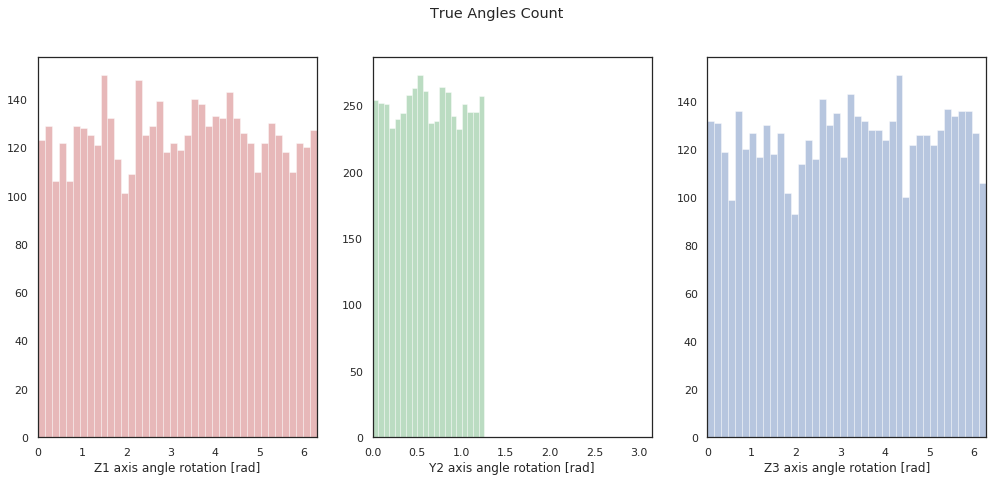

In [111]:
fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("True Angles Count")

sns.distplot(y[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(y[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(y[:,2], kde=False, bins=40, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

##### Predicted Angles [INITIAL]

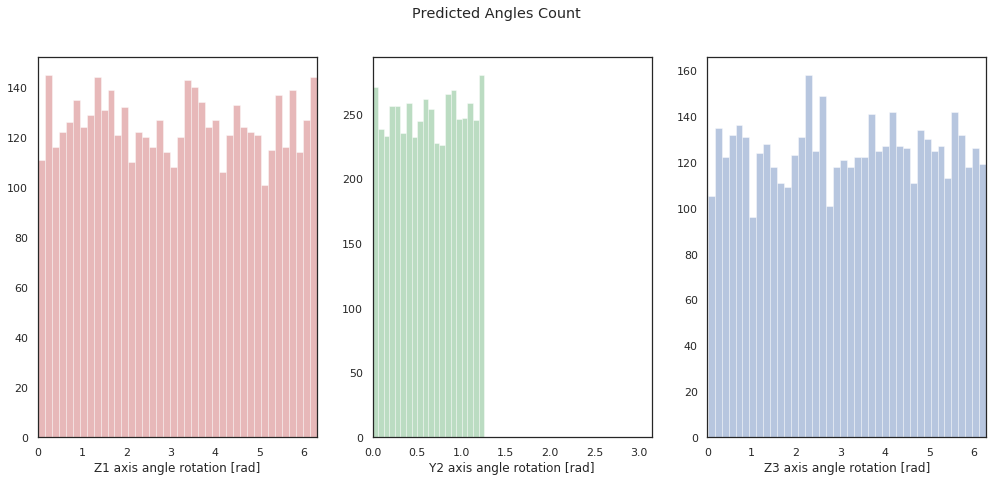

In [110]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])


fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=40, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [114]:
loss_predicted_vs_true_angle(steps=1000, batch_size=256)

step 100/1000 (28s): loss = 1.25e+00
step 200/1000 (56s): loss = 1.01e+00
step 300/1000 (84s): loss = 1.06e+00
step 400/1000 (112s): loss = 1.02e+00
step 500/1000 (140s): loss = 1.21e+00
step 600/1000 (168s): loss = 1.16e+00
step 700/1000 (196s): loss = 1.00e+00
step 800/1000 (224s): loss = 1.07e+00
step 900/1000 (252s): loss = 1.02e+00
step 1000/1000 (279s): loss = 1.08e+00
Mean loss: 1.083657482193315


step 500/5000 (365s): loss = 7.88e-01
step 1000/5000 (710s): loss = 8.16e-01
step 1500/5000 (1065s): loss = 7.44e-01
step 2000/5000 (1420s): loss = 6.93e-01
step 2500/5000 (1775s): loss = 7.68e-01
step 3000/5000 (2128s): loss = 6.83e-01
step 3500/5000 (2486s): loss = 7.44e-01
step 4000/5000 (2838s): loss = 6.53e-01
step 4500/5000 (3195s): loss = 6.22e-01
step 5000/5000 (3545s): loss = 5.97e-01


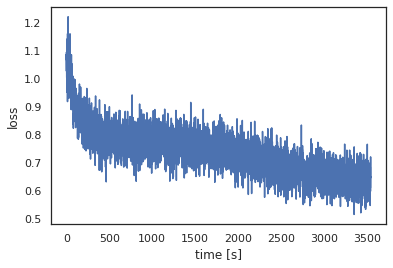

In [115]:
steps=5000
batch_size=256

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = Adam(learning_rate=0.01)

losses = np.empty(steps)
time_start = time()

for step in range(1, steps+1):

    # Sample some pairs.
    #idx1, idx2 = sample_pairs(NUM_PROJECTIONS, batch_size, style="knn_and_random", k=k)
    idx1, idx2 = sample_pairs(projections_range=[4000, 5000], num_pairs=batch_size, style="knn_and_random", k=k)
    #X_data, y_data = create_pairs(X, y, NUM_PAIRS)
    
    # Compute distances between projections
    p1 = [X[i] for i in idx1]
    p2 = [X[i] for i in idx2]
    
    distance_target = d_p(p1, p2)

    a1 = [angles_predicted[i] for i in idx1]
    a2 = [angles_predicted[i] for i in idx2]
    
    # Optimize by gradient descent.
    losses[step-1], gradients = gradient(a1, a2, distance_target, dt_type="dP", space="dQspace")
    optimizer.apply_gradients(zip(gradients, a1 + a2))

    # Periodically report progress.
    if ((step % (steps//10)) == 0) or (step == steps):
        time_elapsed = time() - time_start
        print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

# Plot convergence.
fig, ax = plt.subplots()
ax.plot(np.linspace(0, time()-time_start, steps), losses)
ax.set_xlabel('time [s]')
ax.set_ylabel('loss');

In [116]:
loss_predicted_vs_true_angle(steps=1000, batch_size=256)

step 100/1000 (31s): loss = 7.36e-01
step 200/1000 (63s): loss = 6.93e-01
step 300/1000 (95s): loss = 7.10e-01
step 400/1000 (126s): loss = 6.68e-01
step 500/1000 (158s): loss = 7.10e-01
step 600/1000 (189s): loss = 6.17e-01
step 700/1000 (221s): loss = 6.49e-01
step 800/1000 (252s): loss = 5.38e-01
step 900/1000 (284s): loss = 6.43e-01
step 1000/1000 (315s): loss = 5.89e-01
Mean loss: 0.6617835960769711


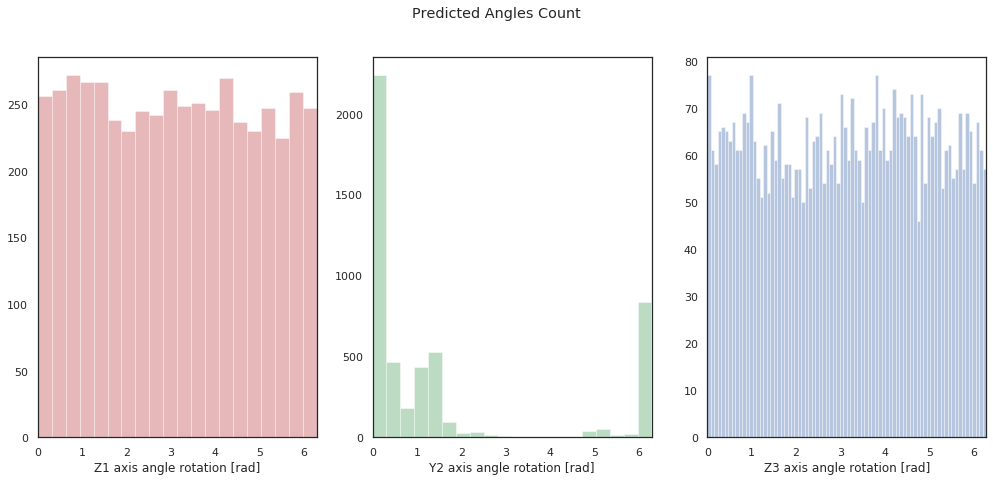

In [117]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])


fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=20, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=80, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [119]:
# plot
all_vectors = RotationMatrix(angles_predicted_plot)
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.pylab.save(f"data/angle_variety/fullpl_predicted_{angle_ranges}.html")
ipv.show()